# Workshop Python: Predicción de precios de propiedades

La métrica que vamos a usar para medir es RMSE (raíz del error cuadrático medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)

In [2]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 6376 observaciones


In [13]:
df.head()

,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,barrio_match,PH,apartment,house,...,VILLA LUGANO,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA,outlier_price_m2
0,-34.589,-58.417,170000.000,40.000,38.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.591,-58.418,90000.000,27.000,27.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.587,-58.437,150000.000,44.000,44.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-34.593,-58.428,154000.000,58.000,58.000,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-34.593,-58.428,154000.000,58.000,58.000,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


__Separar el dataset en entrenamiento (80%) y testing (20%).__

In [4]:
import numpy as np
np.random.seed(123)
from sklearn.model_selection import train_test_split
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape[0], X_test.shape[0])

5100 1276


__Entrenemos un árbol de decisión (parámetros default), medir el RMSE en testing.__

Vamos a medir usando `neg_mean_squared_error` para luego poder obtener el RMSE. Para obtenerlo, tenemos que cambiar los signos y tomar raiz en cada caso.

Usamos cross validation para analizar el resultado de estos parámetros para árboles de decisión. Recordemos que el resultado de cross validation es la performance en testing para cada partición. Una vez evaluado esto, podemos comparar entre modelos y cuando hayamos elegido el favorito, procedemos a ajustar y predecir.

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0, max_depth=5)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [6]:
y_pred = regressor.predict(X_test)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(np.round(rmse, 2))

22247.8


__Entrenemos una regresión lineal (parámetros default), medir el RMSE en testing.__

In [7]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(np.round(rmse, 2))

28166.73


__Analizar el cambio en el RMSE a medida que es más profundo el árbol de decisión, tanto en training como en testing.__

Para esto, iteremos de 5 en 5 en el parámetro `max_depth` y veamos como impacta en el RMSE. 

In [9]:
rmses_train = []
rmses_test = []
for max_depth in range(1,30, 5):
    regressor = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    regressor.fit(X_train, y_train)
    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmses_train.append(rmse_train)
    rmses_test.append(rmse_test)

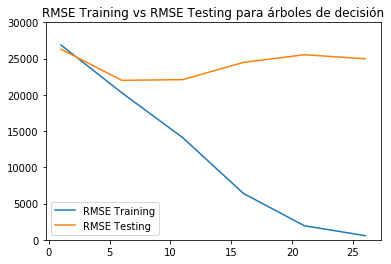

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(range(1,30, 5), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 5), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para árboles de decisión")
plt.show()

Podemos ver aquí como el modelo presenta sobreajuste dado que a mayor complejidad (en este caso, mayor profundidad del árbol) más diferencia entre los resultados de training y testing. También observamos como la curva de testing decrece y luego vuelvo a crecer. El punto donde se minimiza está relacionado con el tradeoff entre sesgo y varianza.

__Calcular el RMSE promedio de cross validation (10 folds) para un árbol de decisión de máxima profundidad 5.__

Dado que la implementación de scikit-learn usá el `neg_mean_squared_error` para calcular en cross validation, definamos el método nmsq2rmse para pasar de esa métrica al RMSE que venimos trabajando.

In [12]:
def nmsq2rmse(score):
    return np.sqrt(-score)

In [13]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=5)
neg_scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmses = [nmsq2rmse(score) for score in neg_scores]
print("RMSE: USD %0.2f (+/- USD %0.2f)" % (np.mean(rmses), np.std(rmses) * 2))

RMSE: USD 21973.59 (+/- USD 1317.07)


Para ver el resultado final, reentrenamos al regresor y mostramos en un dataframe la comparación entre los valores reales, los predichos y su diferencia

In [10]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [11]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [12]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,80000.000,139000.000,59000.000
1,128000.000,165000.000,37000.000
2,150000.000,162000.000,12000.000
3,85000.000,110000.000,25000.000
4,135000.000,110000.000,25000.000
5,135000.000,155100.000,20100.000
6,68000.000,75000.000,7000.000
7,110000.000,165000.000,55000.000
8,134000.000,168000.000,34000.000
9,110000.000,73000.000,37000.000


## Consignas

En todos los casos se van a requerir corridas usando cross validation con 5 folds.

1. Experimentar con diferentes configuraciones de parámetros de max_depth y min_sample_split. Presentar resultados de entrenamiento y testeo.
2. Experimentar con regresión ridge con diferentes parámetros de alpha.Presentar resultados de entrenamiento y testeo.
3. Evaluar para el mejor modelo de cada punto las 20 propiedades con error más alto y más bajo. Sacar conclusiones.

In [110]:
#Consigna 1
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def nmsq2rmse(score):
    return np.sqrt(-score) #

ids = [] # Es una lista vacia para los ids
avg = [] # Es una lista vacia para los promedios
std = [] # Es una lista vacia para los desvios estandar

# Hago 2 for para ir variando los valores de max_depth (profundidad del arbol) 
# y min_samples_split (valor con el que separa las ramas)

for max_depth in range (1,50,2):
    for min_samples_split in range (2,30,10):
        
        # con esto define el regresor con el que se va a trabajar, en este caso se usa un arbol de decision
        regressor = DecisionTreeRegressor(random_state=0, max_depth = max_depth, min_samples_split = min_samples_split)
        
        # calcula el scoring (que funcion va a usar, en este caso es mean squared error) usando crossvalidation
        # y despues hace positivos los resultados
        neg_scores = cross_val_score (regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmses = [nmsq2rmse(score) for score in neg_scores]
        
        # aca vas definiendo las listas que van a ser las columnas
        identificador = "{}-{}".format(max_depth,min_samples_split)
        rmse_avg = np.mean(rmses)
        rmse_std = np.std(rmses)
        
        # aca vas agregando cada resultado en cada iteracion
        ids.append(identificador)
        avg.append(rmse_avg)
        std.append(rmse_std)    
        
        #regressor.fit(X_train, y_train)
        #y_pred = regressor.predict(X_test)
        #rmse_y_pred = mean_squared_error (y_test.values, y_pred)

In [102]:
ID = pd.Series(ids)
AVG = pd.Series(avg)
STD = pd.Series(std)
#val_real = pd.Series(y_test.values)
#val_rmse_pred = pd.Series(rmse_y_pred)

df = pd.concat ([ID.rename('ID'),AVG.rename('AVG'),STD.rename('STD')], axis = 1) #,val_real.rename('Valor real'),val_rmse_pred.rename('RMSE Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')
df

,ID,AVG,STD
0,1-2,26970.406,319.552
1,1-12,26970.406,319.552
2,1-22,26970.406,319.552
3,3-2,23570.819,273.728
4,3-12,23570.819,273.728
5,3-22,23570.819,273.728
6,5-2,22119.889,504.945
7,5-12,22121.983,505.428
8,5-22,22120.849,505.228
9,7-2,21809.819,474.912


In [103]:
df.loc[df['STD'] == min(df['STD'])]

,ID,AVG,STD
3,3-2,23570.819,273.728
4,3-12,23570.819,273.728
5,3-22,23570.819,273.728


In [108]:
regressor = DecisionTreeRegressor(random_state=0, max_depth = 3, min_samples_split = 2)        
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [109]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,80000.000,116459.196,36459.196
1,128000.000,147340.361,19340.361
2,150000.000,147340.361,2659.639
3,85000.000,108058.638,23058.638
4,135000.000,132310.952,2689.048
5,135000.000,116459.196,18540.804
6,68000.000,108058.638,40058.638
7,110000.000,116459.196,6459.196
8,134000.000,132310.952,1689.048
9,110000.000,83498.219,26501.781
